## Tarea

Importa las librerías necesarias para resolver los siguientes ejercicios (no necesitaras ninguna que no hayamos utilizado nosotros)

In [1]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
from shapely.ops import nearest_points


#### 1.
Grafica la división estatal de México (usando el shapefile que usamos en la clase) en diferentes tonos de algún color que elijas. Pintalos según su área. Los estados más oscuros siendo los más grandes

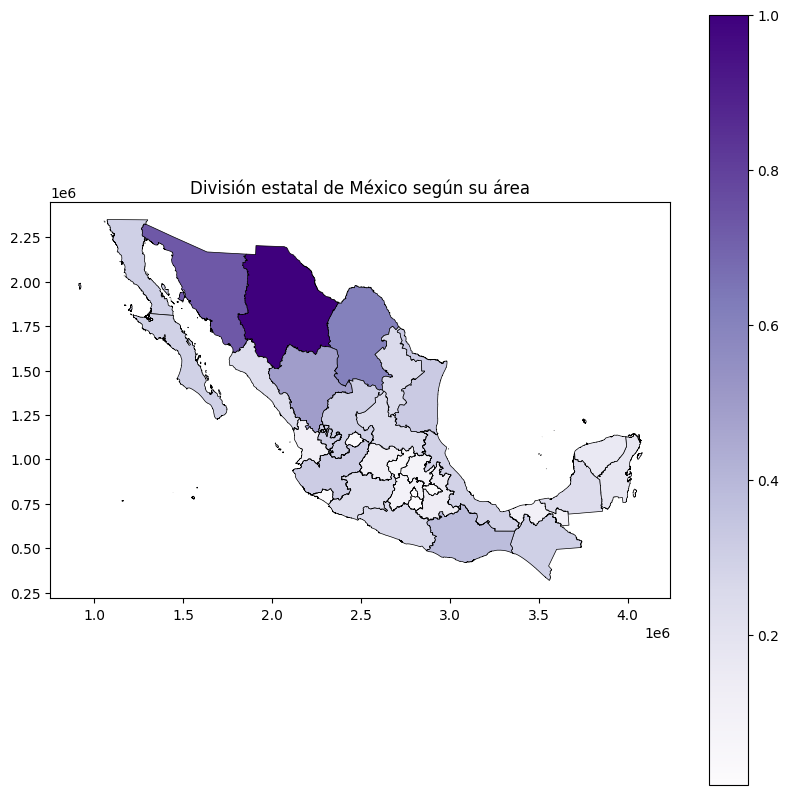

In [2]:
estados = gpd.read_file('Estados-20240511T173211Z-001/Estados/conjunto_de_datos')
estados.tail(5)


#saber el área de cada estado 
estados['area'] = estados.geometry.area

#pa saber qué tanto color debe de tener cada estado en uan escala del 0 al 1
estados['color'] = estados['area'] / estados['area'].max()

# Graficar los estados (en morado porque we love morado, fuck em kids with blue)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
estados.plot(ax=ax, column='color', cmap='Purples', edgecolor='black', linewidth=0.5, legend=True)
ax.set_title('División estatal de México según su área')
plt.show()

#### 2.
Crea un área de 5km alrededor de cada escuela. Calcula el área total cubierta y saca el porcentaje de área del país cubierta por escuelas.
Tip: cuidado con las intersecciones y las unidades!

In [3]:
escuelas = gpd.read_file('Escuelas-20240511T173935Z-001/Escuelas/conjunto_de_datos/denue_inegi_61_.shp')
escuelas.head(5)

,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry
0,8362275,02004611611001791000000000U8,ACADEMIA DE DANZA DAENSEU,None,611611,Escuelas de arte del sector privado,0 a 5 personas,AVENIDA,ARANJUEZ,AVENIDA,...,5940,018,None,ACADEMIADEDANZADAENSEU@GMAIL.COM,None,Fijo,32.504878,-116.866163,2019-11,POINT (-116.86616 32.50488)
1,117215,02004611611000961000000000U8,ACADEMIA DE DANZA KULIMA,None,611611,Escuelas de arte del sector privado,0 a 5 personas,CALLE,CASTILLO DE CHAPULTEPEC,CALLE,...,3287,044,6643810100,KUILIMAACADEMIA@HOTMAIL.COM,None,Fijo,32.530170,-116.986028,2014-12,POINT (-116.98603 32.53017)
2,6908025,02001611611000701000000000U4,ACADEMIA DE DANZA CONGAS CHIC,None,611611,Escuelas de arte del sector privado,0 a 5 personas,AVENIDA,PRIMER AYUNTAMIENTO,CALLE,...,7875,018,None,SANDRADELGADO286@GMAIL.COM,None,Fijo,31.861220,-116.590644,2019-11,POINT (-116.59064 31.86122)
3,126361,02004611611000802000000000U4,ACADEMIA DE DANZA COPELIA,None,611611,Escuelas de arte del sector privado,6 a 10 personas,CALLE,D,CALLE,...,4069,015,6646229426,INFOCOPELIATIJ@GMAIL.COM,None,Fijo,32.482036,-116.941097,2014-12,POINT (-116.94110 32.48204)
4,7368721,02004611611001701000000000U7,ACADEMIA DE DANZA VILLA DI DANZA,None,611611,Escuelas de arte del sector privado,0 a 5 personas,CALLE,MONTES DE OCA,CALLE,...,5851,005,6643751622,None,None,Fijo,32.506026,-116.865755,2019-11,POINT (-116.86576 32.50603)


In [4]:
escuelas = escuelas.to_crs(epsg=6362)

# Crear un buffer de 5 km alrededor de cada escuela y convertirlo en GeoDataFrame
escuelas_buffer = escuelas.buffer(5000)
escuelas_buffer_df = gpd.GeoDataFrame(geometry=escuelas_buffer, crs=escuelas.crs)

# Cargar el shapefile del área del país y re-proyectarlo para que coincida con el CRS de las escuelas
pais = gpd.read_file('Estados-20240511T173211Z-001/Estados/conjunto_de_datos')
pais = pais.to_crs(epsg=6362)

# Calcular la intersección entre los buffers de las escuelas y el polígono del país
intersecciones = gpd.overlay(escuelas_buffer_df, pais, how='intersection')

# Calcular el área total cubierta por las escuelas
area_total_cubierta = intersecciones.geometry.area.sum()

# Calcular el área total del país
area_total_pais = pais.geometry.area.sum()

# Calcular el porcentaje de área del país cubierta por escuelas
porcentaje_area_cubierto = (area_total_cubierta / area_total_pais) * 100

print("Área total cubierta por escuelas:", area_total_cubierta, "metros cuadrados")
print("Área total del país:", area_total_pais, "metros cuadrados")
print("Porcentaje de área del país cubierta por escuelas:", porcentaje_area_cubierto, "%")

Área total cubierta por escuelas: 11396767271226.604 metros cuadrados
Área total del país: 1954679731500.8462 metros cuadrados
Porcentaje de área del país cubierta por escuelas: 583.0503630625931 %


#### 3.
Calcula la distancia entre la CDMX y todos los demás estados de la república. 
Bonus: punto extra si lo haces usando las fronteras y no los centroides.

In [5]:
#Usando centroides
centroide_CDMX = estados[estados["NOMGEO"] == 'Ciudad de México']['geometry'].centroid.iloc[0]
#usando el mismo fokin iloc que nos regañaría Uumami

# Calcular la distancia entre la CDMX y cada uno de los otros estados
distancias = {}
for index, row in estados.iterrows():
    if row['NOMGEO'] != 'Ciudad de México':
        estado_centroide = row['geometry'].centroid
        distancia = centroide_CDMX.distance(estado_centroide) / 1000  
        distancias[row['NOMGEO']] = distancia

# Imprimir las distancias
for estado, distancia in distancias.items():
    print(f"Distancia entre CDMX y {estado}: {distancia:.2f} km")



Distancia entre CDMX y Aguascalientes: 449.91 km
Distancia entre CDMX y Baja California: 2026.65 km
Distancia entre CDMX y Baja California Sur: 1505.08 km
Distancia entre CDMX y Campeche: 922.72 km
Distancia entre CDMX y Coahuila de Zaragoza: 931.20 km
Distancia entre CDMX y Colima: 522.21 km
Distancia entre CDMX y Chiapas: 770.60 km
Distancia entre CDMX y Chihuahua: 1285.31 km
Distancia entre CDMX y Durango: 858.95 km
Distancia entre CDMX y Guanajuato: 265.26 km
Distancia entre CDMX y Guerrero: 195.77 km
Distancia entre CDMX y Hidalgo: 135.20 km
Distancia entre CDMX y Jalisco: 488.68 km
Distancia entre CDMX y México: 53.85 km
Distancia entre CDMX y Michoacán de Ocampo: 287.58 km
Distancia entre CDMX y Morelos: 59.45 km
Distancia entre CDMX y Nayarit: 655.43 km
Distancia entre CDMX y Nuevo León: 698.36 km
Distancia entre CDMX y Oaxaca: 384.33 km
Distancia entre CDMX y Puebla: 133.42 km
Distancia entre CDMX y Querétaro: 189.02 km
Distancia entre CDMX y Quintana Roo: 1154.33 km
Distancia

In [6]:
#Usando Fronteras 
cdmx = estados[estados['NOMGEO'] == 'Ciudad de México'].geometry.unary_union

# Calcular la distancia entre la CDMX y todos los demás estados
distancias = {}
for index, row in estados.iterrows():
    if row['NOMGEO'] != 'Ciudad de México':
        estado = row['geometry']
        distancia = cdmx.distance(estado)
        distancias[row['NOMGEO']] = distancia


for estado, distancia in distancias.items():
    print(f"Distancia entre CDMX y {estado}: {distancia:.2f} unidades")

##OJO MARCA 0.0 UNIDADES A MÉXICO Y MORELOS PORQUE SON LOS ESTADOS CON LOS QUE TOPA SUS FRONTERAS 


Distancia entre CDMX y Aguascalientes: 379557.12 unidades
Distancia entre CDMX y Baja California: 1645551.35 unidades
Distancia entre CDMX y Baja California Sur: 1127556.53 unidades
Distancia entre CDMX y Campeche: 682973.83 unidades
Distancia entre CDMX y Coahuila de Zaragoza: 573236.16 unidades
Distancia entre CDMX y Colima: 431986.96 unidades
Distancia entre CDMX y Chiapas: 579734.46 unidades
Distancia entre CDMX y Chihuahua: 913759.02 unidades
Distancia entre CDMX y Durango: 618267.66 unidades
Distancia entre CDMX y Guanajuato: 128951.55 unidades
Distancia entre CDMX y Guerrero: 50114.40 unidades
Distancia entre CDMX y Hidalgo: 28546.02 unidades
Distancia entre CDMX y Jalisco: 305170.99 unidades
Distancia entre CDMX y México: 0.00 unidades
Distancia entre CDMX y Michoacán de Ocampo: 88191.63 unidades
Distancia entre CDMX y Morelos: 0.00 unidades
Distancia entre CDMX y Nayarit: 508830.11 unidades
Distancia entre CDMX y Nuevo León: 412739.02 unidades
Distancia entre CDMX y Oaxaca: 14

#### 4.
Metete al INEGI y descarga el shapefile de nombre "Servicios profesionales, científicos y técnicos" de 2023 (más info en el READ ME y en la presentación). Grafica las escuelas (sólo las primarias, secundarias y prepas), y los servicios que se muestran en este shapefile (las escuelas de un color y los servicios de otro). También grafica los estados. Comenta si ves alguna relación entre la localización de estas escuelas y los servicios.

In [10]:
servicios = gpd.read_file('tareas/200258_aic/denue_00_54_shp/conjunto_de_datos')
servicios.head(5)

,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry
0,5240,01001541941000131001000000U1,VETERINARIA MASCOTITAS,None,541941,Servicios veterinarios para mascotas prestados...,0 a 5 personas,AVENIDA,CONVENCION DE 1914 SUR,CALLE,...,0869,004,4499781776,None,None,Fijo,21.865883,-102.296168,2010-07,POINT (-102.29617 21.86588)
1,28079,01001541941000991000000000U8,VETERINARIA MISHO,None,541941,Servicios veterinarios para mascotas prestados...,0 a 5 personas,CALLE,FELIPE ANGELES,CALLE,...,091A,010,4491141677,None,None,Fijo,21.871951,-102.273028,2014-12,POINT (-102.27303 21.87195)
2,42202,01001541941000771000000000U4,VETERINARIA MAINVET CENTER,None,541941,Servicios veterinarios para mascotas prestados...,0 a 5 personas,AVENIDA,AGUASCALIENTES NORTE,CALLE,...,3083,018,None,None,None,Fijo,21.915086,-102.277956,2014-12,POINT (-102.27796 21.91509)
3,44080,01001541941000851000000000U4,VETERINARIA MARYCAN,None,541941,Servicios veterinarios para mascotas prestados...,0 a 5 personas,CALLE,PISCIS,CALLE,...,3187,036,4492242459,None,None,Fijo,21.903773,-102.275770,2014-12,POINT (-102.27577 21.90377)
4,33506,01001812990000511000000000U0,VETERINARIA NARICES FRESCAS,None,541941,Servicios veterinarios para mascotas prestados...,0 a 5 personas,AVENIDA,AVENIDA DE LOS MAESTROS,AVENIDA,...,287A,012,4493378304,None,None,Fijo,21.858007,-102.314479,2014-12,POINT (-102.31448 21.85801)


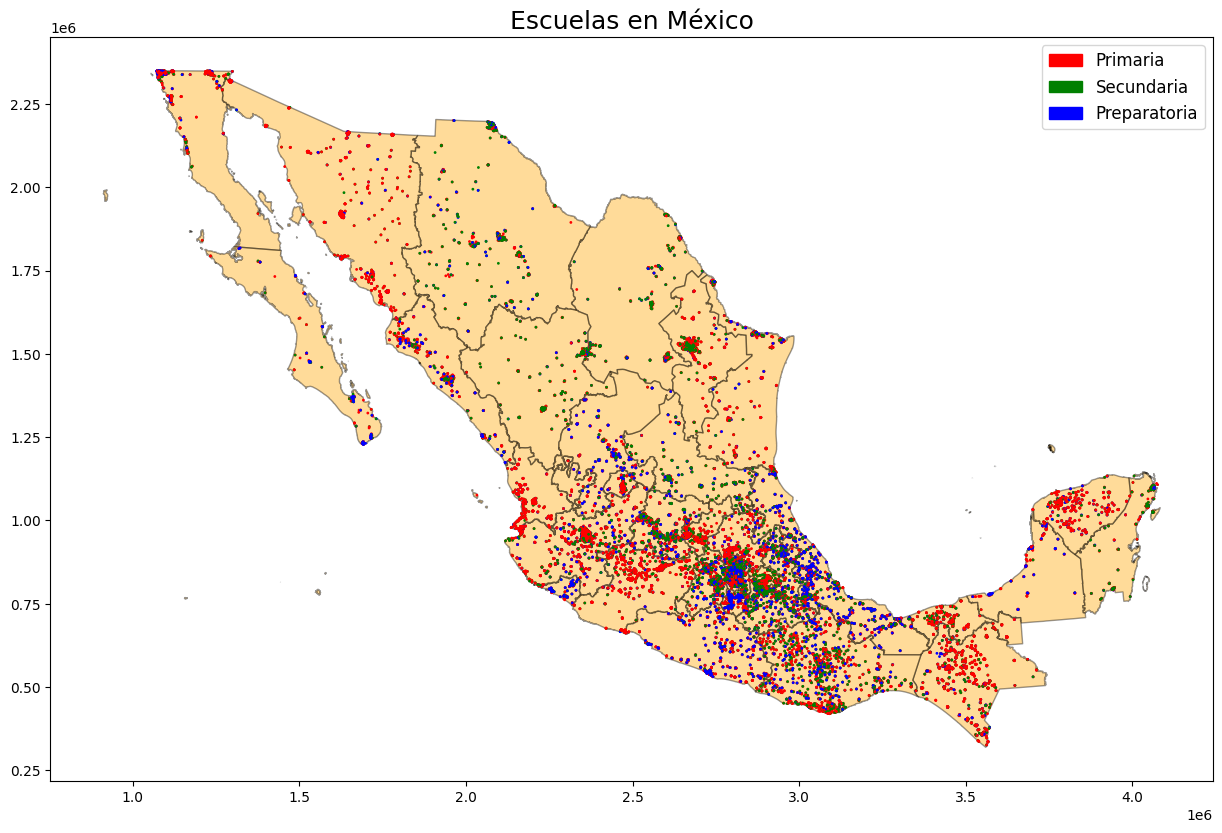

In [16]:
mexico_crs = "EPSG:6362"

# Cambiamos el CRS al de méxico
escuelas = escuelas.to_crs(mexico_crs)
estados = estados.to_crs(mexico_crs)

escuelas_in_ent = gpd.sjoin(escuelas, estados, how='inner', predicate='within')
# Define the regex patterns
regex_primaria = r"(?i)(primaria|escuela básica|escuela elemental)"
regex_secundaria = r"(?i)(secundaria|escuela media|educación media)"
regex_prep_bach = r"(?i)(preparatoria|bachillerato|prepa|colegio)"

# Function to determine color based on regex matching
def assign_color(row):
    if pd.notna(row['nom_estab']):
        if re.search(regex_prep_bach, row['nom_estab']):
            return 'blue'  # Color for Prepa
        elif re.search(regex_secundaria, row['nom_estab']):
            return 'green'  # Color for Secundaria
        elif re.search(regex_primaria, row['nom_estab']):
            return 'red'  # Color for Primaria
    return 'gray'  # Color if none match

# Apply the function to each row
escuelas_in_ent['color'] = escuelas_in_ent.apply(assign_color, axis=1)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
estados.plot(ax=ax, color='orange', edgecolor='black', alpha=0.4)
escuelas_sin_gris = escuelas_in_ent[escuelas_in_ent['color']!='gray']
escuelas_sin_gris.plot(ax=ax, color=escuelas_sin_gris['color'], markersize=1, legend=True)

legend_patches = [
    mpatches.Patch(color='red', label='Primaria'),
    mpatches.Patch(color='green', label='Secundaria'),
    mpatches.Patch(color='blue', label='Preparatoria'),
]
ax.set_aspect('equal')
ax.legend(handles=legend_patches, loc='upper right', fontsize=12)
ax.set_title("Escuelas en México", fontsize=18)
plt.show()


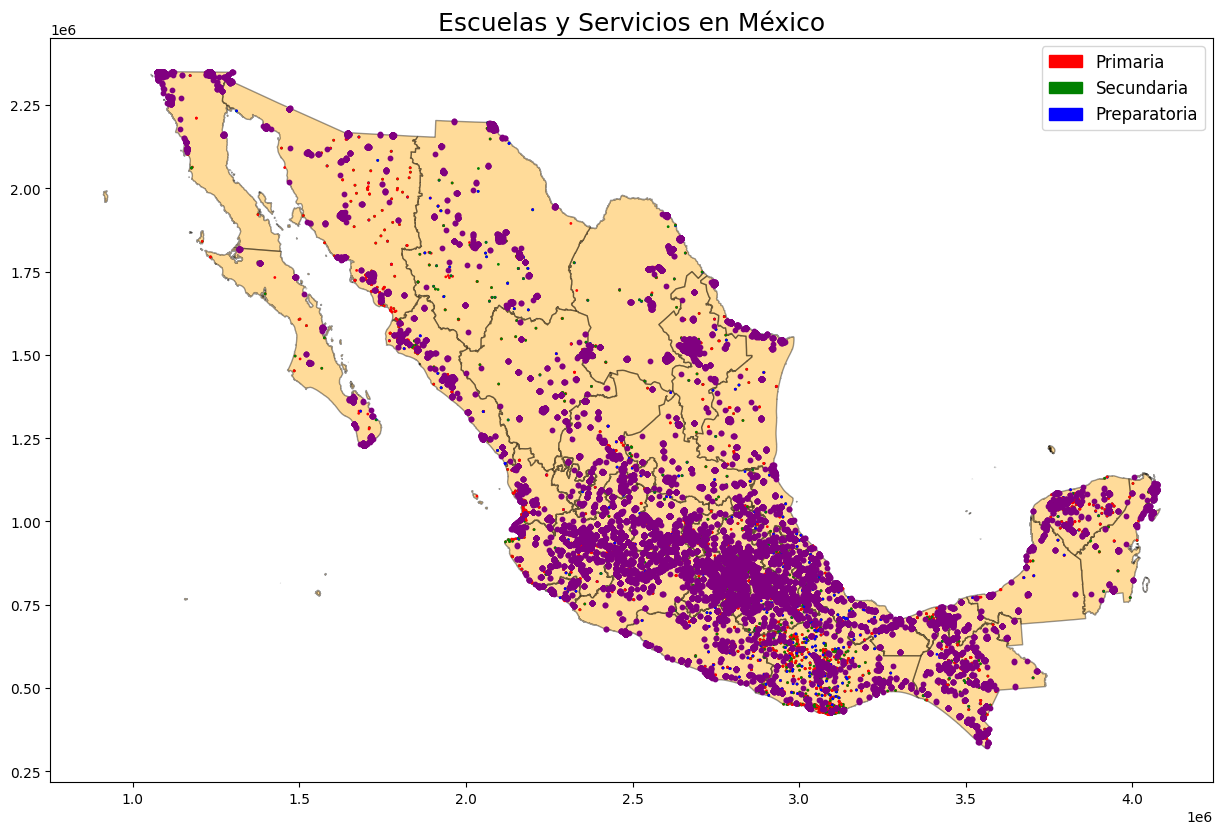

In [20]:
##ESTE ES EL QUE RESUELVE LA PREGUNTA, SOLO TUVE QUE PONER EL DE ARRIBA PARA VER MÁS O MENOS CÓMO ESTABAN LAS ESCUELAS 


# Cambiar el CRS al de México
mexico_crs = "EPSG:6362"
servicios = servicios.to_crs(mexico_crs)

# Cambiar el CRS de las escuelas si no lo has hecho ya
escuelas = escuelas.to_crs(mexico_crs)

# Realizar la unión espacial de las escuelas y los estados
escuelas_in_ent = gpd.sjoin(escuelas, estados, how='inner', predicate='within')

# Definir los patrones de regex para identificar el tipo de escuela
regex_primaria = r"(?i)(primaria|escuela básica|escuela elemental)"
regex_secundaria = r"(?i)(secundaria|escuela media|educación media)"
regex_prep_bach = r"(?i)(preparatoria|bachillerato|prepa|colegio)"

# Función para determinar el color de las escuelas basado en regex
def assign_color_escuela(row):
    if pd.notna(row['nom_estab']):
        if re.search(regex_prep_bach, row['nom_estab']):
            return 'blue'  # Color para Prepa
        elif re.search(regex_secundaria, row['nom_estab']):
            return 'green'  # Color para Secundaria
        elif re.search(regex_primaria, row['nom_estab']):
            return 'red'  # Color para Primaria
    return 'gray'  # Color si ninguna coincide

# Aplicar la función a cada fila de escuelas
escuelas_in_ent['color'] = escuelas_in_ent.apply(assign_color_escuela, axis=1)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Graficar los estados
estados.plot(ax=ax, color='orange', edgecolor='black', alpha=0.4)

# Graficar las escuelas
escuelas_sin_gris = escuelas_in_ent[escuelas_in_ent['color']!='gray']
escuelas_sin_gris.plot(ax=ax, color=escuelas_sin_gris['color'], markersize=1, legend=True)

# Crear leyenda para las escuelas
legend_patches_escuelas = [
    mpatches.Patch(color='red', label='Primaria'),
    mpatches.Patch(color='green', label='Secundaria'),
    mpatches.Patch(color='blue', label='Preparatoria'),
]
ax.legend(handles=legend_patches_escuelas, loc='upper right', fontsize=12)

# Graficar los servicios
servicios.plot(ax=ax, color='purple', markersize=10, legend=True)

# Ajustar el aspecto de la gráfica
ax.set_aspect('equal')
ax.set_title("Escuelas y Servicios en México", fontsize=18)
plt.show()


Comentario: Se puede ver como se concentra (de nuevo) los servicios en lo que se puede llamar 2el centro del país" y como es basicamente la misma concentración que ocurría con las escuela. 

Parece ser que se tienden a centrar los servicios profesionales, científicos y técnicos en los mismos lugares en los cuáles tiende a juntarse las escuelas. No me parece descabellado porque fin y el cabo podríamos pensar que "ahí se junta la civilización en México"

Un ejemplo muy claro es el desierto de chihuahua y cómo en él se aprecian una o dos escuelas MUY lejanas de sí mismas, pero los servicios basicamente no se utilizan ahí. 